# Shape Recognition Notebook

* We have been handed a shape recognition challenge as part of [UIzard's](https://uizard.io/) interviewing process.

* Our goal is to implement an algorithm able to recognize and count the number of occurence of three different shapes (square, circle and triangle) in a given image.

**Input:**
* ``<image path string>``

**Output:**
* Three integers separated with commas (in a string)
* *Example*: ``3, 2, 1``


*Comment:* Given the output format, we could in principle have an accurate output *shape-wise* and *image-wise* if the number of **false positives** and **false negatives** compensate for each shape. By false positive I mean an area of the image that was mistakenly identified as a shape and by false negative an area of the image that contains a shape that was missed.

## Imports

In [1]:
# Printing images in the notebook
%matplotlib inline

In [2]:
# OS file manipulation package
import os

# Numerical data handling package
import numpy as np

# Image handling package
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Columnar data handling package
import pandas as pd

# Computer vision package
import cv2

# Import custom detector
from shape_recognition.shapedetector import ShapeDetector

In [3]:
print("OpenCV version: ", cv2.__version__)

OpenCV version:  3.4.0


## Data Exploration

In [4]:
training_data_path = './training_data/'

assert os.path.exists(training_data_path), "Please move the 'training_data' folder into the current folder"

In [5]:
image_files_list = [file for file in os.listdir(training_data_path) if file.endswith('jpg')]
target_files_list = [file for file in os.listdir(training_data_path) if file.endswith('txt')]
filename_list = list(set([file.split('.')[0] for file in os.listdir(training_data_path)]))
# Count .jpg file
print("There are %d images..." % len(image_files_list))
# Count .txt file
print("There are %d targets..." % len(target_files_list))
assert len(image_files_list) == len(target_files_list)
print("There are %d unique filenames..." % len(filename_list))
# Check if each image has a corresponding target
assert sorted([file.split('.')[0] for file in image_files_list]) ==\
    sorted([file.split('.')[0] for file in target_files_list])

There are 5000 images...
There are 5000 targets...
There are 5000 unique filenames...


### Data visualization

In [6]:
np.random.seed(42)
files_subset = np.random.choice(filename_list, 16)
print("We randomly select %d images..." % len(files_subset))

We randomly select 16 images...


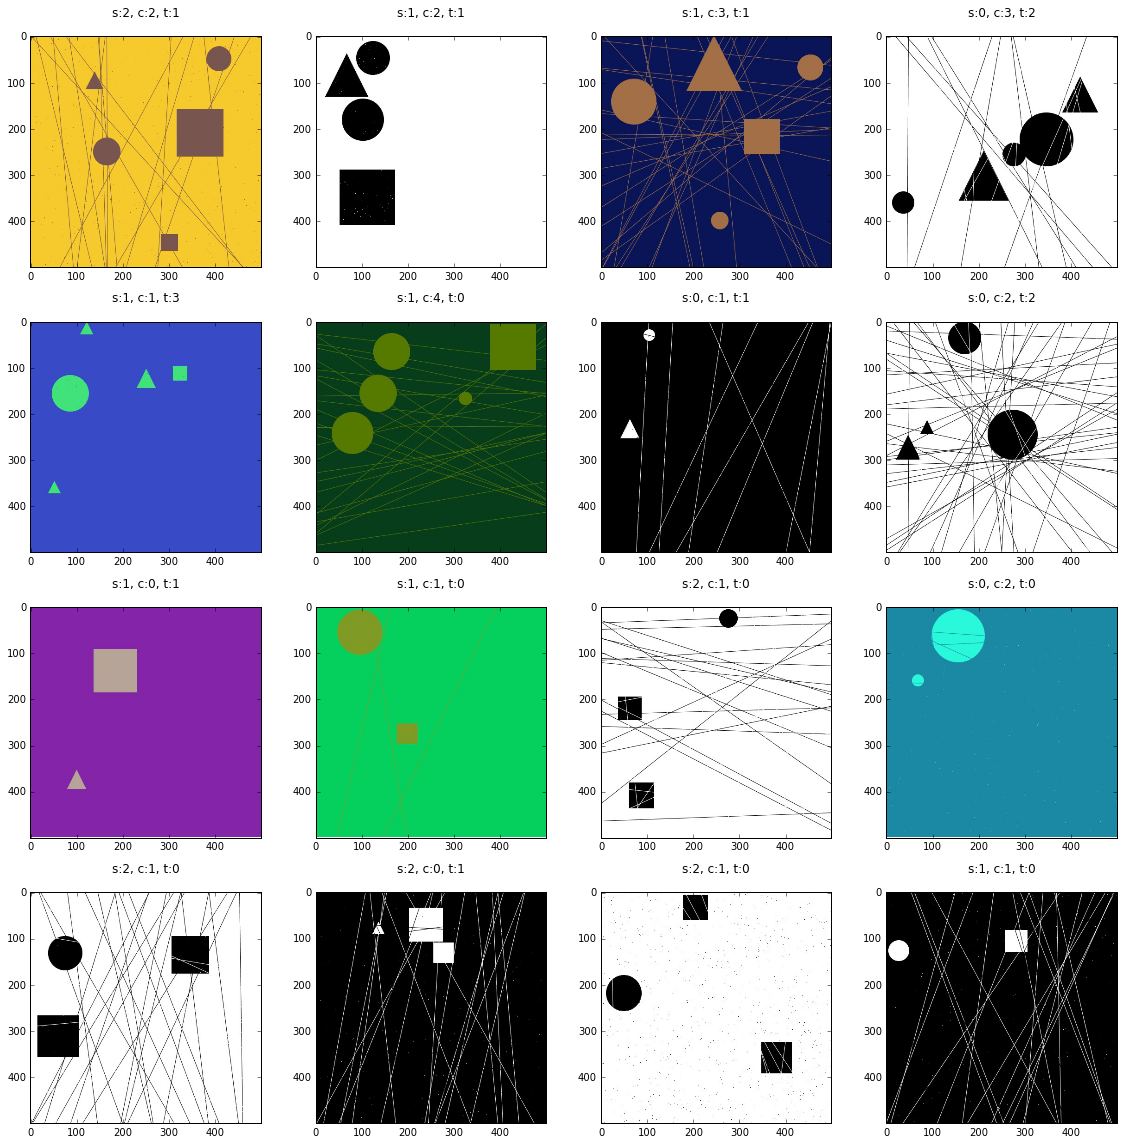

In [7]:
# Display some images
plt.figure(figsize=(16, 16))
for i, file in enumerate(files_subset):
    plt.subplot(4, 4, i + 1)
    with open(training_data_path + file + '.txt', 'r') as f:
        target = f.read()
    plt.title(target)    
    img = mpimg.imread(training_data_path + file + '.jpg')
    plt.imshow(img)
plt.tight_layout();

* As we see here some images are **noisy** - either because there are some lines scattered on the image or small dots that do not count as circles.

* It's worth mentioning that the triangles are always in the *same configuration* (i.e. the highest point is always 1 of the 3 corners while the other 2 are horizontal). If we want to generate more training data using basic symmetries we may as well avoid **horizontal symmetry** as it would add a *confusion factor* in our data. We may instead use the **vertically-centered symmetry**. In addition they are **isosceles** triangles.

* Some shapes are **partially merged** and there can be any merging configuration. This will render our task more difficult but reflects *real* data.

* There is little hindsight in having colored images instead of **grayscale** versions. We might opt to translate the image colors into a grayscale to be more efficient at processing the data while avoiding unnecessary information that could result in added confusion. 

### Labels Distribution

* Let's turn the target files into a ``numpy`` array.
* The typical string stored in a text file is as follows: ``s:2, c:1, t:0`` meaning there are 2 squares, 1 circle and 0 triangles in the associated image. We therefore use splitting operations on the file content to store the occurences in a ``numpy`` array where each *row* represents a **sample** and each *column* represents a **category** (namely square, circle and triangle in this order).
* We expect to have a 5000 by 3 target matrix.

In [8]:
# Extract labels from text file
targets_list = list()

for file in filename_list:
    with open(training_data_path + file + '.txt', 'r') as f:
        target = f.read().replace('\n', '')
        scores = [int(shape.split(':')[1]) for shape in target.split(',')]
        targets_list.append(scores)
targets = np.array(targets_list).astype(np.int)
print("Target matrix shape:", targets.shape)
assert targets.shape[0] == 5000
assert targets.shape[1] == 3

Target matrix shape: (5000, 3)


* Let's use ``pandas`` to figure out the labels distribution.

In [9]:
targets_df = pd.DataFrame(targets, columns=['s', 'c', 't'])
targets_df.replace(0, np.nan, inplace=True)
targets_df['Total'] = targets_df.sum(1)
targets_df.info()
targets_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
s        4020 non-null float64
c        4019 non-null float64
t        3239 non-null float64
Total    5000 non-null float64
dtypes: float64(4)
memory usage: 156.3 KB


s    c    t  Total
0  2.0  2.0  1.0    5.0
1  1.0  1.0  1.0    3.0
2  1.0  2.0  2.0    5.0
3  1.0  2.0  NaN    3.0
4  1.0  3.0  1.0    5.0

In [10]:
targets_df.describe()

s            c            t        Total
count  4020.000000  4019.000000  3239.000000  5000.000000
mean      1.464428     2.133615     1.489040     3.857000
std       0.632124     1.054660     0.696626     1.493518
min       1.000000     1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000     3.000000
50%       1.000000     2.000000     1.000000     4.000000
75%       2.000000     3.000000     2.000000     5.000000
max       4.000000     7.000000     5.000000    10.000000

In [11]:
print("There are %d squares..." % targets_df['s'].sum())
print("There are %d circles..." % targets_df['c'].sum())
print("There are %d triangles..." % targets_df['t'].sum())
print("There are %d shapes in total..." % targets_df['Total'].sum())
assert targets_df['s'].sum() + targets_df['c'].sum() + targets_df['t'].sum() ==\
targets_df['Total'].sum()

There are 5887 squares...
There are 8575 circles...
There are 4823 triangles...
There are 19285 shapes in total...


In [12]:
max_s = targets_df['s'].max()
print("Maximum number of squares in 1 image: %d" % max_s)
max_c = targets_df['c'].max()
print("Maximum number of circles in 1 image: %d" % max_c)
max_t = targets_df['t'].max()
print("Maximum number of triangles in 1 image: %d" % max_t)

Maximum number of squares in 1 image: 4
Maximum number of circles in 1 image: 7
Maximum number of triangles in 1 image: 5


### Data exploration conclusions

There are a few comments to be made regarding the data.

* First, we can expect to have more circles than either squares or triangles on average.
* Second, the ``min`` value from the shape columns is misleading as we can indeed have no squares (or circles or triangles) in a given image as alluded by the ``count`` row.
* There are no empty images. The least shapes there are is 1 as alluded by the Total ``min``. This time the ``min`` value is accurate as the data replacement happens before computing the Total.
* We cannot expect to have more than 4 squares in a given image.
* As we know we will be evaluated on *500 images that we have access to* we can fix a **threshold** on the maximum number of shape occurences to happen on an image. We can only do this because we know the label distribution. 
* Additionally we cannot expect to have more than 10 shapes in a given image.

This data analysis gives us clues when analyzing our model's results and can be quite handy when cleaning said results.

## List of challenges


**Preprocessing**
* <del> Keep the color scale or not?</del>
  * Turn images into grayscale and even binary scale.
* <del> Normalize each image value in the range [0, 1]?</del>
  * Unnecessary. 8-bits precision in grayscale is sufficient.
* <del> How to handle small noisy dots?</del>
  * Apply smoothing using ``cv2.medianBlur``. It does not eliminate every dots but reduce the likelihood of getting false positives.
* <del>How to handle lines?</del>
  *  Same as above. Smoothing helps *breaking* the lines.
* <del>Is the frame too heavy? How to resize?</del>
  * Downsizing led to worse results. Computation time is not an issue here.

**Modelisation**
* <del>Histogram of Oriented Gradients (HOG) or raw images?</del>
  * HOGs provide useful features but these are hard to leverage using conventional Machine Learning classifiers as each shape can have multiple occurences in any area of the image. Implementing Region of Interests (ROI) remains tricky as double counts can easily happen. Raw images can be preprocessed by classical computer vision algorithms.
* <del>How to prevent HOG features number from exploding without resizing?</del>
  * Do not use them? In all seriousness, the number of HOG features on 500x500 images would have been huge. Lowering it would have required downsizing perhaps losing information in the process.
* <del>Conventional Machine Learning or Deep Learning?</del>
  * Neither. We use classical computer vision algorithms instead.
  * We could have used Deep Neural Networks such as [Faster-RCNN](https://arxiv.org/pdf/1506.01497.pdf) that consists in merging a *Region Proposal Network* (RPN) and a *Fast-Recurrent Convolutional Neural Network* (Fast-RCNN) that triggers an *attention* mechanism - the model *knows* where to look at - but the training part is tricky since it would require *annotated anchors* (we only have the true number of each shape for each image) and possibly a lot more training examples. Data augmentation would have been needed - if we were to generalize our model to unseen data. We could have used a *vertical symmetry* to double the training set sizes but would still fall short of the several 10,000 of samples - still we could have generated other training images randomly using OpenCV.
  * As explained above, relying on conventional Machine Learning algorithms to tackle a multi-class and multi-occurrence object detection task is tricky.

**Detection**
* <del>How to handle multi-class?</del>
  * Contour detection paired with counting the number of counter edges can differentiate the shapes.
* <del>How to handle multi-occurrences?</del>
  * This is a tricky task to tackle using conventional Machine Learning as classifiers are often *binary* classifiers. Therefore it requires sliding through the image at different scale to identify a shape while avoiding double counting.

## Shape Detection Pipeline

* *Preprocessing*
  
  * Load image in grayscale
  * Use median Blurring to smooth the image and eliminate potential false positives


* *Circles Recognition*

  * Use Hough's Transform to detect circles (``cv2.HoughCircles``)
  * ``cv2.HoughCircles`` requires setting parameters that can be quite unstable. We use the available *training* data to optimize the parameters in regards of our custom ``F1-score``.
  * We retrieve the number of detected circles.


* *Squares and Triangles Recognition*
  * We add one preprocessing step as we turn the grayscale image into a binary image for better contour detection.
  * Triangles (respectively Squares) are defined as polygons with exactly 3 sides (respectively 4 equal sides). We can use these properties when looping through the identified contours.
  * As in the Circles Recognition task, finding contours requires setting the perimeter ratio given to the polynomial approximator ``cv2.approxPolyDP``.
  * Additionally we can set a threshold on the contour perimeter to discard noisy blobs as is done in ``ShapeDetector.detect``.
  * We are able to retrieve the number of detected squares and triangles based on the ``ShapeDetector.detect`` method output.
  * We later separated square and triangle recognition by setting hyper-parameters based on the shape we wish to detect.
  
  
* *Output Formating*

  * We output the number of squares, circles and triangles in a comma separated string as required.

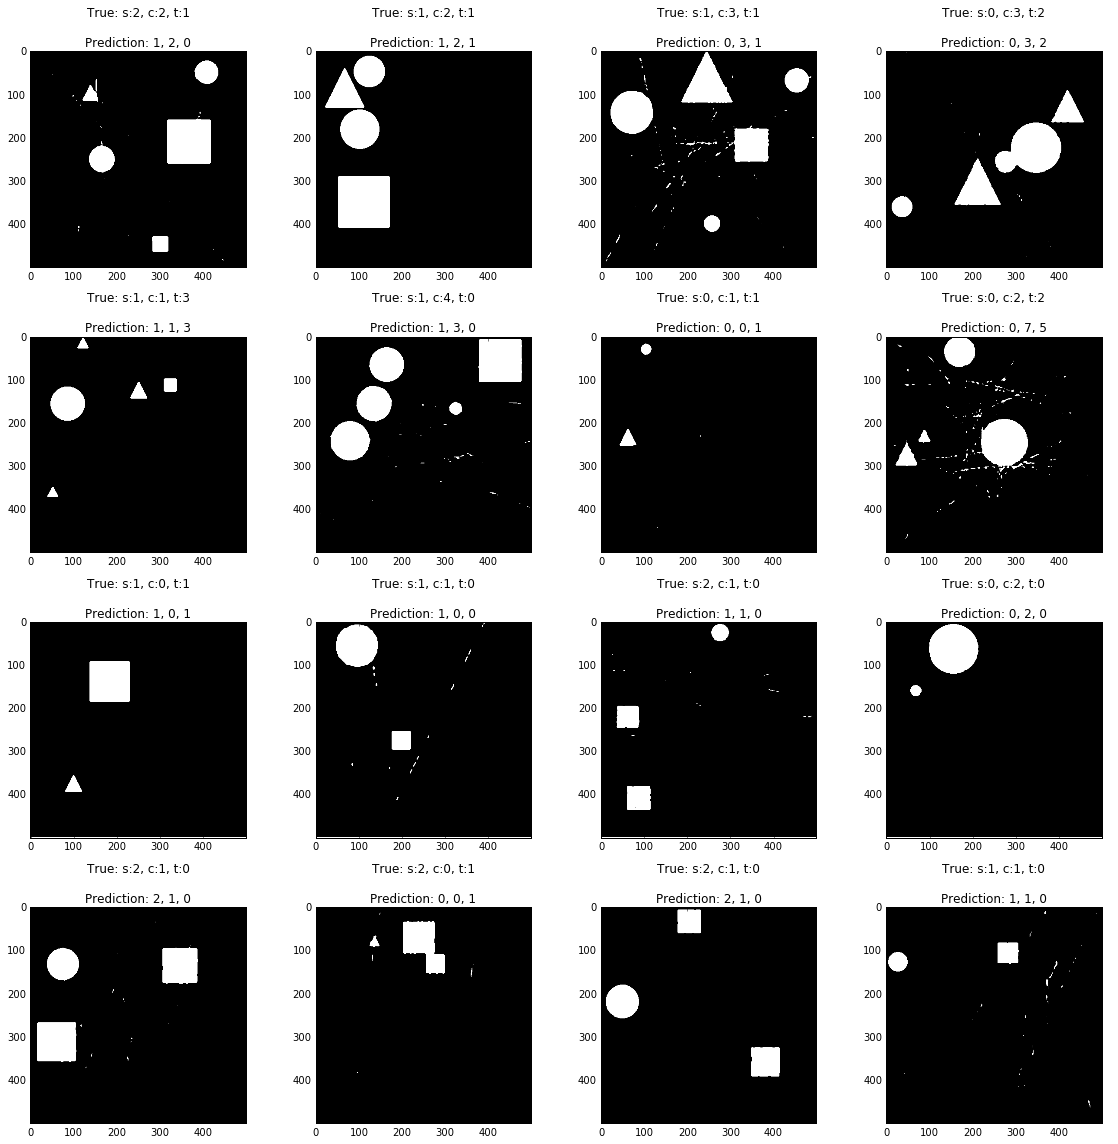

In [13]:
plt.figure(figsize=(16, 16))

for i, file in enumerate(files_subset):
    # Select the current subplot
    plt.subplot(4, 4, i + 1)
    # Open the ground truth file
    with open(training_data_path + file + '.txt', 'r') as f:
        target = f.read()
       
    ### PREPROCESSING ###
    # Load image into grayscale
    im_g = cv2.imread(training_data_path + file + '.jpg', cv2.IMREAD_GRAYSCALE)
    
    # Smoothing
    im_g = cv2.medianBlur(im_g, 5)
    
    
    ### CIRCLES DETECTION ###
    # Compute circles using Hough Transform
    circles = cv2.HoughCircles(im_g.copy(), cv2.HOUGH_GRADIENT, dp=1, 
                               minDist=50, param1=70, param2=30,
                               minRadius=5, maxRadius=100)
    # Retrieve number of circles
    n_circles = 0 if circles is None else circles.shape[1]
    
    ### SQUARES AND TRIANGLES DETECTION ###
    
    # Apply binary threshold
    thresh, im_bw = cv2.threshold(im_g, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Change background color if current is white
    # as findContours takes a binary image where
    # objects are white and background is black
    u_counts = np.unique(im_bw, return_counts=True)[1]
    if len(u_counts) == 2: # Image is not uniformly black (or white)
        im_bw = cv2.bitwise_not(im_bw) if (u_counts[0] < u_counts[1]) else im_bw
    
    # Find contours
    contours = cv2.findContours(im_bw, cv2.RETR_LIST,
                               cv2.CHAIN_APPROX_SIMPLE)[1]
    # Instantiate Shape Detector
    shape_detector = ShapeDetector()
    # Retrieve shapes list
    shapes = [shape_detector.detect(c, 0.04) for c in contours]
    # Retrieve number of squares
    n_squares = shapes.count("square")
    # Retrieve number of triangles
    n_triangles = shapes.count("triangle")
    
    ### OUTPUT GENERATION ###
    # Format prediction output
    prediction = ', '.join([str(n_squares), str(n_circles), str(n_triangles)])
    # Set title to compare ground truth to prediction
    plt.title("True: %s\nPrediction: %s" % (target, prediction))
    # Display image
    plt.imshow(im_bw, plt.cm.gray)
plt.tight_layout(); 

## Evaluation


* We are about to evaluate our performances on the whole dataset.
* First we store the data into a single array. Since this operation is too heavy on RAM, we randomly select a validation dataset - 20 % of the original dataset.

In [14]:
# Store the grayscale images into a single array
imgs = list()
# Store the ground truth into a single array
labels = list()
# We take 10% of the dataset as validation data on which to compute metrics
validation_set = np.random.choice(filename_list, round(len(filename_list) / 5))

n_validation_set = len(validation_set)

print("Loading and preprocessing %d images..." % n_validation_set)
for i, file in enumerate(validation_set):
    with open(training_data_path + file + '.txt', 'r') as f:
        # Read target text file
        target = f.read().replace('\n', '')
        # Retrieve scores
        scores = [int(shape.split(':')[1]) for shape in target.split(',')]
        labels.append(scores)
    ### PREPROCESSING ###
    # Load image into grayscale
    im_g = cv2.imread(training_data_path + file + '.jpg', cv2.IMREAD_GRAYSCALE)
    
    # Smoothing
    im_g = cv2.medianBlur(im_g, 5)
    
    imgs.append(im_g)
    
    # Dynamic counter
    if i != 0 and i % (n_validation_set / 10) == 0:
        print("%d%%..." % (round(100 * i / n_validation_set)))

print("Done loading...")
X = np.array(imgs, dtype=np.uint8)
del imgs
Y = np.array(labels, dtype=np.uint8)
del labels
print("X shape: (%d, %d, %d)" % X.shape)
print("Y shape: (%d, %d)" % Y.shape)
assert X.shape[0] == n_validation_set
assert X.shape[1] == 500
assert X.shape[2] == 500
assert X.shape[0] == Y.shape[0]
assert Y.shape[1] == 3

Loading and preprocessing 1000 images...
10%...
20%...
30%...
40%...
50%...
60%...
70%...
80%...
90%...
Done loading...
X shape: (1000, 500, 500)
Y shape: (1000, 3)


In [16]:
Y_pred = np.zeros_like(Y)
print("Detecting shapes in validation set (%d images)..." % n_validation_set)
for i in range(n_validation_set):
    
    im_g = X[i]
    ### CIRCLES DETECTION ###
    # Compute circles using Hough Transform
    circles = cv2.HoughCircles(im_g.copy(), cv2.HOUGH_GRADIENT, dp=1, 
                               minDist=50, param1=70, param2=30,
                               minRadius=5, maxRadius=100)
    # Retrieve number of circles
    n_circles = 0 if circles is None else min(circles.shape[1], max_c)
    
    ### SQUARES AND TRIANGLES DETECTION ###
    
    # Apply binary threshold
    thresh, im_bw = cv2.threshold(im_g, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Change background color if current is white
    # as findContours takes a binary image where
    # objects are white and background is black
    u_counts = np.unique(im_bw, return_counts=True)[1]
    if len(u_counts) == 2: # Image is not uniformly black (or white)
        im_bw = cv2.bitwise_not(im_bw) if (u_counts[0] < u_counts[1]) else im_bw
    
    
    # Find contours
    contours = cv2.findContours(im_bw, cv2.RETR_LIST, # Returns all level of hierarchy 
                               cv2.CHAIN_APPROX_SIMPLE)[1] # Removes redundant point and save memory
    # Instantiate Shape Detector
    shape_detector = ShapeDetector()
    # Retrieve shapes list
    shapes = [shape_detector.detect(c, 0.04) for c in contours]
    # Retrieve number of squares
    n_squares = min(shapes.count("square"), max_s) 
    # Retrieve number of triangles
    n_triangles = min(shapes.count("triangle"), max_t)
    
    ### OUTPUT GENERATION ###
    # Format prediction output
    #prediction = ', '.join([str(n_squares), str(n_circles), str(n_triangles)])
    Y_pred[i] = np.array([n_squares, n_circles, n_triangles], dtype=np.uint8)
    
    if i != 0 and i % (n_validation_set / 10) == 0:
        print("%d%%..." % (round(100 * i / n_validation_set)))
        
print("Done detecting...")

Detecting shapes in validation set (1000 images)...
10%...
20%...
30%...
40%...
50%...
60%...
70%...
80%...
90%...
Done detecting...


### Prediction Distribution

In [17]:
pred_df = pd.DataFrame(Y_pred, columns=['s', 'c', 't'])
pred_df.replace(0, np.nan, inplace=True)
pred_df['Total'] = pred_df.sum(1)
pred_df.info()
pred_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
s        756 non-null float64
c        750 non-null float64
t        591 non-null float64
Total    1000 non-null float64
dtypes: float64(4)
memory usage: 31.3 KB


s    c    t  Total
0  1.0  3.0  2.0    6.0
1  2.0  4.0  NaN    6.0
2  1.0  2.0  NaN    3.0
3  NaN  5.0  1.0    6.0
4  NaN  2.0  2.0    4.0

In [18]:
pred_df.describe()

s           c           t        Total
count  756.000000  750.000000  591.000000  1000.000000
mean     1.417989    2.249333    1.495770     3.643000
std      0.617531    1.168326    0.774312     1.668033
min      1.000000    1.000000    1.000000     0.000000
25%      1.000000    1.000000    1.000000     3.000000
50%      1.000000    2.000000    1.000000     4.000000
75%      2.000000    3.000000    2.000000     5.000000
max      4.000000    7.000000    5.000000    12.000000

In [19]:
print("Squares\nGround truth mean: %.2f\nPrediction mean: %.2f\n" 
     % (targets_df['s'].mean(), pred_df['s'].mean()))
print("Circles\nGround truth mean: %.2f\nPrediction mean: %.2f\n" 
     % (targets_df['c'].mean(), pred_df['c'].mean()))
print("Triangles\nGround truth mean: %.2f\nPrediction mean: %.2f\n" 
     % (targets_df['t'].mean(), pred_df['t'].mean()))

Squares
Ground truth mean: 1.46
Prediction mean: 1.42

Circles
Ground truth mean: 2.13
Prediction mean: 2.25

Triangles
Ground truth mean: 1.49
Prediction mean: 1.50



* The results seem reasonable on average but we need to compute the ``precision`` and ``recall`` metrics to get a clear idea on how we perform.

* We also implement our custom ``shape_wise_accuracy`` and ``image_wise_accuracy`` metrics.

### Metrics

#### Accuracy

* **shape-wise accuracy** is the accuracy over the total number of successfully counted shapes in the evaluation set.
* **image-wise accuracy** is the accuracy over the total number of images where all shapes were successfully counted. 

In [20]:
from shape_recognition.metrics import shape_wise_accuracy
from shape_recognition.metrics import image_wise_accuracy

In [21]:
print("Shape-wise accuracy: %.2f" % shape_wise_accuracy(Y, Y_pred))

Shape-wise accuracy: 0.87


In [22]:
print("Image-wise accuracy: %.2f" % image_wise_accuracy(Y, Y_pred))

Image-wise accuracy: 0.70


#### Precision, Recall and F1-score

* As described above, we consider a prediction to fall under the *False Positive* (FP) category whenever it predicted a number of shape occurrences higher than the ground truth. The number of FP is equal to the absolute difference.
* Similarly we consider a prediction to be *False Negative* (FN) whenever it predicted a number of shape occurrences lower than the ground truth. The number of FN is equal to the absolute difference.
* Finally we consider a prediction to be a *True Positive* (TP) whenever the number of occurrences predicted is equal to the ground truth. The number of TP is equal to the value of ground truth occurrences.

* All of this is obviously flawed since we are not asked nor given the shapes bounding boxes.

In [23]:
from shape_recognition.metrics import custom_precision_recall

In [24]:
print("Squares\nPrecision: %.2f\nRecall: %.2f\nF1-score: %.2f\n" 
      % custom_precision_recall(Y[:, 0], Y_pred[:, 0]))

print("Circles\nPrecision: %.2f\nRecall: %.2f\nF1-score: %.2f\n" 
      % custom_precision_recall(Y[:, 1], Y_pred[:, 1]))

print("Triangles\nPrecision: %.2f\nRecall: %.2f\nF1-score: %.2f\n" 
      % custom_precision_recall(Y[:, 2], Y_pred[:, 2]))

Squares
Precision: 0.93
Recall: 1.00
F1-score: 0.96

Circles
Precision: 0.89
Recall: 0.94
F1-score: 0.91

Triangles
Precision: 0.84
Recall: 0.87
F1-score: 0.86



* The ``precision`` and ``recall`` results underline that our prediction is quite conservative as it misses more shapes than it invent.

* We have a worse precision when dealing with Triangles.

## Hyper-parameters optimization

In this section we leverage our validation set to perform a custom Grid Search in order to obtain the Circles detection hyper-parameters that maximize our results. We do the same to the Squares and Triangles detection hyper-parameters.

We can only explore a limited sub-space of all the hyper-parameters space to avoid dimension exploding.

In [25]:
# Circle detection hyper-parameters grid search

# Initial scores
max_f1 = 0.
max_f1_precision = 0.
max_f1_recall = 0.
best_config = ''

# Parameters grid
minDists = [50, 100]
param1s = [70, 100]
param2s = [20, 30]
minRads = [5, 10]
maxRads = [100, 150]

Y_pred = np.zeros_like(Y[:, 1])

n_combinations = len(minDists) * len(param1s) * len(param2s) *\
    len(minRads) * len(maxRads)
print("Number of combinations explored: %d" % n_combinations)

for minDist in minDists:
    for param1 in param1s:
        for param2 in param2s:
            for minRad in minRads:
                for maxRad in maxRads:
                    for i in range(n_validation_set):

                        im_g = X[i]
                        ### CIRCLES DETECTION ###
                        # Compute circles using Hough Transform
                        circles = cv2.HoughCircles(im_g.copy(), cv2.HOUGH_GRADIENT, dp=1, 
                                                   minDist=minDist, param1=param1, param2=param2,
                                                   minRadius=minRad, maxRadius=maxRad)
                        # Retrieve number of circles
                        Y_pred[i] = 0 if circles is None else min(circles.shape[1], max_c)
                    
                    precision, recall, f1_score = custom_precision_recall(Y[:, 1], Y_pred)
                    if f1_score > max_f1:
                        max_f1 = f1_score
                        max_f1_precision = precision
                        max_f1_recall = recall
                        best_config = "minDist:%d\nparam1:%d\nparam2:%d\nminRad:%d\nmaxRad:%d" % (minDist,
                                                                                                  param1,
                                                                                                  param2,
                                                                                                  minRad,
                                                                                                  maxRad)
print("Circle Detection best configuration:\n%s\n\nPrecision: %.2f\nRecall: %.2f\nF1-score: %.2f" % 
     (best_config, max_f1, max_f1_precision, max_f1_recall))

Number of combinations explored: 32
Circle Detection best configuration:
minDist:50
param1:70
param2:30
minRad:5
maxRad:100

Precision: 0.91
Recall: 0.89
F1-score: 0.94


* Let us investigate the hyper-parameter influence on squares and triangles detection separately. We will also tweak the perimeter threshold.

In [28]:
# Squares detection hyper-parameter grid search

# Initial scores
max_f1 = 0.
max_f1_precision = 0.
max_f1_recall = 0.
best_config = ''

# Parameters grid
eps_range = 0.01 * np.arange(1, 6)
thresh_ps = [30, 50, 70]


Y_pred = np.zeros_like(Y[:, 0])
print("Number of combinations explored: %d" %
      (len(eps_range) * len(thresh_ps)))
for eps in eps_range:
    for thresh_p in thresh_ps:
        for i in range(n_validation_set):
            im_g = X[i]
            
            # Apply binary threshold
            thresh, im_bw = cv2.threshold(im_g, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            
            # Change background color if current is white
            # as findContours takes a binary image where
            # objects are white and background is black
            u_counts = np.unique(im_bw, return_counts=True)[1]
            if len(u_counts) == 2: # Image is not uniformly black (or white)
                im_bw = cv2.bitwise_not(im_bw) if (u_counts[0] < u_counts[1]) else im_bw
                
            # Find contours
            contours = cv2.findContours(im_bw, cv2.RETR_LIST,
                                       cv2.CHAIN_APPROX_SIMPLE)[1]
            # Instantiate Shape Detector
            shape_detector = ShapeDetector()
            # Retrieve shapes list
            shapes = [shape_detector.detect(c, eps, thresh_p) for c in contours]
            # Retrieve number of squares
            Y_pred[i] = min(shapes.count("square"), max_s)
            
        precision, recall, f1_score = custom_precision_recall(Y[:, 0], Y_pred)
        if f1_score > max_f1:
            max_f1 = f1_score
            max_f1_precision = precision
            max_f1_recall = recall
            best_config = "eps:%.2f\nthresh_p:%d" % (eps, thresh_p)
            

print("Square Detection best configuration:\n%s\n\nPrecision: %.2f\nRecall: %.2f\nF1-score: %.2f" % 
     (best_config, max_f1, max_f1_precision, max_f1_recall))

Number of combinations explored: 15
Square Detection best configuration:
eps:0.04
thresh_p:30

Precision: 0.96
Recall: 0.93
F1-score: 1.00


In [29]:
# Triangles detection hyper-parameter grid search

# Initial scores
max_f1 = 0.
max_f1_precision = 0.
max_f1_recall = 0.
best_config = ''

# Parameters grid
eps_range = 0.01 * np.arange(1, 9)
thresh_ps = [50, 70]


Y_pred = np.zeros_like(Y[:, 2])
print("Number of combinations explored: %d" %
      (len(eps_range) * len(thresh_ps)))
for eps in eps_range:
    for thresh_p in thresh_ps:
        for i in range(n_validation_set):
            im_g = X[i]
            
            # Apply binary threshold
            thresh, im_bw = cv2.threshold(im_g, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

            # Change background color if current is white
            # as findContours takes a binary image where
            # objects are white and background is black
            u_counts = np.unique(im_bw, return_counts=True)[1]
            if len(u_counts) == 2: # Image is not uniformly black (or white)
                im_bw = cv2.bitwise_not(im_bw) if (u_counts[0] < u_counts[1]) else im_bw

            # Find contours
            contours = cv2.findContours(im_bw, cv2.RETR_LIST,
                                       cv2.CHAIN_APPROX_SIMPLE)[1]
            # Instantiate Shape Detector
            shape_detector = ShapeDetector()
            # Retrieve shapes list
            shapes = [shape_detector.detect(c, eps, thresh_p) for c in contours]
            # Retrieve number of squares
            Y_pred[i] = min(shapes.count("triangle"), max_t)
            
        precision, recall, f1_score = custom_precision_recall(Y[:, 2], Y_pred)
        if f1_score > max_f1:
            max_f1 = f1_score
            max_f1_precision = precision
            max_f1_recall = recall
            best_config = "eps:%.2f\nthresh_p:%d" % (eps, thresh_p)
            

print("Triangle Detection best configuration:\n%s\n\nPrecision: %.2f\nRecall: %.2f\nF1-score: %.2f" % 
     (best_config, max_f1, max_f1_precision, max_f1_recall))

Number of combinations explored: 16
Triangle Detection best configuration:
eps:0.08
thresh_p:70

Precision: 0.92
Recall: 0.87
F1-score: 0.97


## Final settings

In [31]:
Y_pred = np.zeros_like(Y)
print("Detecting shapes in validation set (%d images)..." % n_validation_set)
for i in range(n_validation_set):
    
    im_g = X[i]
    ### CIRCLES DETECTION ###
    # Compute circles using Hough Transform
    circles = cv2.HoughCircles(im_g.copy(), cv2.HOUGH_GRADIENT, dp=1, 
                               minDist=50, param1=70, param2=30,
                               minRadius=5, maxRadius=100)
    # Retrieve number of circles
    n_circles = 0 if circles is None else min(circles.shape[1], max_c)
    
    ### SQUARES DETECTION ###
    
    # Apply binary threshold
    thresh, im_bw = cv2.threshold(im_g, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Change background color if current is white
    # as findContours takes a binary image where
    # objects are white and background is black
    u_counts = np.unique(im_bw, return_counts=True)[1]
    if len(u_counts) == 2: # Image is not uniformly black (or white)
                im_bw = cv2.bitwise_not(im_bw) if (u_counts[0] < u_counts[1]) else im_bw
    # Find contours
    contours = cv2.findContours(im_bw, cv2.RETR_LIST,
                               cv2.CHAIN_APPROX_SIMPLE)[1]
    
    # Instantiate Shape Detector
    shape_detector = ShapeDetector()
    # Retrieve shapes list
    shapes = [shape_detector.detect(c, 0.04, 30) for c in contours]
    # Retrieve number of squares
    n_squares = min(shapes.count("square"), max_s)
    
    
    # Retrieve shapes list
    shapes = [shape_detector.detect(c, 0.08, 70) for c in contours]
    # Retrieve number of triangles
    n_triangles = min(shapes.count("triangle"), max_t)
    
    ### OUTPUT GENERATION ###
    # Format prediction output
    #prediction = ', '.join([str(n_squares), str(n_circles), str(n_triangles)])
    Y_pred[i] = np.array([n_squares, n_circles, n_triangles], dtype=np.uint8)
    
    if i != 0 and i % (n_validation_set / 10) == 0:
        print("%d%%..." % (round(100 * i / n_validation_set)))
        
print("Done detecting...")

Detecting shapes in validation set (1000 images)...
10%...
20%...
30%...
40%...
50%...
60%...
70%...
80%...
90%...
Done detecting...


In [32]:
print("Shape-wise accuracy: %.2f" % shape_wise_accuracy(Y, Y_pred))

Shape-wise accuracy: 0.89


In [33]:
print("Image-wise accuracy: %.2f" % image_wise_accuracy(Y, Y_pred))

Image-wise accuracy: 0.74


* We can see that we slightly improved the shape-wise and image-wise accuracy.